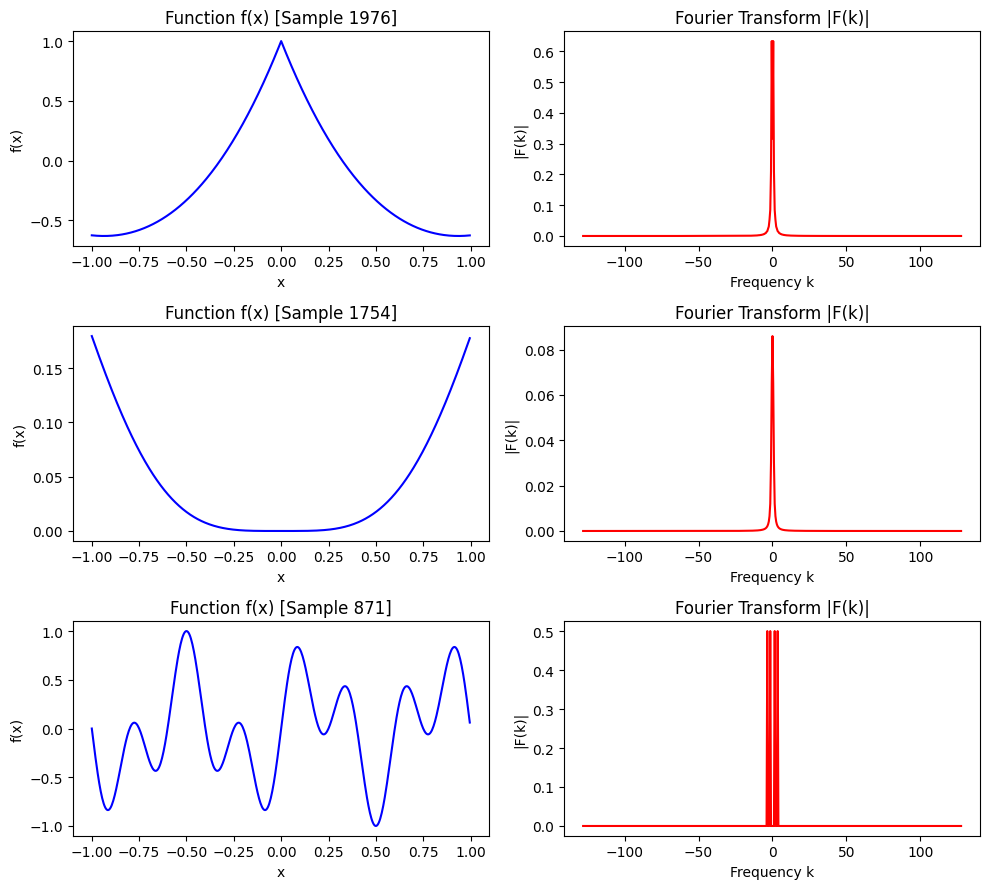

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Reuse dataset generator from before
import numpy as np
from scipy.special import legendre, chebyt, jv, hermite, eval_laguerre

def make_function(x, kind="random", max_freq=10):
    """
    Generate a diverse set of functions for Fourier testing.

    Parameters:
        x        : array of input points
        kind     : type of function to generate; if 'random', one is picked randomly
        max_freq : maximum frequency for Fourier-type functions

    Returns:
        f        : array of function values
    """
    
    if kind == "random":
        kind = np.random.choice([
            "fourier", "poly", "gaussian", "gaussian_mixture",
            "damped_sine", "exp_decay", "piecewise", "trig_combo",
            "legendre", "chebyshev", "bessel",
            "hermite", "laguerre",
            "windowed_sine", "rect_pulse", "sawtooth", "triangle",
            "modulated", "chirp", "spikes", "wavelet"
        ])
    
    # ----------------- Standard types -----------------
    if kind == "fourier":
        coeffs = np.random.randn(max_freq)
        f = np.zeros_like(x, dtype=float)
        for n, a in enumerate(coeffs, start=1):
            f += a * np.sin(np.pi * n * x)
        return f

    elif kind == "poly":
        coeffs = np.random.randn(5)
        return sum(c * x**i for i, c in enumerate(coeffs))

    elif kind == "gaussian":
        mu, sigma = np.random.uniform(-0.5, 0.5), np.random.uniform(0.05, 0.5)
        return np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

    elif kind == "gaussian_mixture":
        num_gaussians = np.random.randint(2, 4)
        f = np.zeros_like(x)
        for _ in range(num_gaussians):
            mu, sigma, amp = np.random.uniform(-0.5,0.5), np.random.uniform(0.05,0.3), np.random.uniform(0.5,2.0)
            f += amp * np.exp(-((x - mu)**2) / (2 * sigma**2))
        return f

    elif kind == "damped_sine":
        freq = np.random.uniform(1, max_freq)
        decay = np.random.uniform(0.5, 2.0)
        phase = np.random.uniform(0, 2*np.pi)
        return np.exp(-decay * np.abs(x)) * np.sin(2 * np.pi * freq * x + phase)

    elif kind == "exp_decay":
        lam = np.random.uniform(0.5, 2.0)
        return np.exp(-lam * np.abs(x))

    elif kind == "piecewise":
        split = np.random.uniform(x[0], x[-1])
        return np.piecewise(x, [x < split, x >= split],
                            [lambda t: t**2, lambda t: -t + split])

    elif kind == "trig_combo":
        f = np.zeros_like(x)
        num_terms = np.random.randint(2, 5)
        for _ in range(num_terms):
            amp = np.random.uniform(0.5, 2.0)
            freq = np.random.randint(1, max_freq)
            phase = np.random.uniform(0, 2*np.pi)
            f += amp * (np.sin(2*np.pi*freq*x + phase) + np.cos(2*np.pi*freq*x + phase))
        return f

    # ----------------- Special polynomials -----------------
    elif kind == "legendre":
        deg = np.random.randint(1, 6)
        P = legendre(deg)
        return P(x)

    elif kind == "chebyshev":
        deg = np.random.randint(1, 6)
        T = chebyt(deg)
        return T(x)

    elif kind == "bessel":
        order = np.random.randint(0, 6)
        k = np.random.uniform(1, 10)
        return jv(order, k * x)

    elif kind == "hermite":
        deg = np.random.randint(1,5)
        H = hermite(deg)
        return H(x)

    elif kind == "laguerre":
        deg = np.random.randint(1,5)
        return eval_laguerre(deg, np.abs(x))  # Laguerre defined on [0,∞)

    # ----------------- Windowed / localized functions -----------------
    elif kind == "windowed_sine":
        freq = np.random.uniform(1, max_freq)
        alpha = np.random.uniform(1,5)
        return np.sin(2*np.pi*freq*x) * np.exp(-alpha*x**2)

    elif kind == "rect_pulse":
        start, end = np.random.uniform(-0.5, 0), np.random.uniform(0,0.5)
        return np.where((x>=start) & (x<=end), 1.0, 0.0)

    elif kind == "sawtooth":
        return 2*(x - np.floor(x + 0.5))  # normalized sawtooth

    elif kind == "triangle":
        return 2*np.abs(2*(x - np.floor(x + 0.5))) - 1

    elif kind == "modulated":
        f1 = np.sin(5*np.pi*x)
        f2 = np.cos(2*np.pi*x)
        return f1*f2

    elif kind == "chirp":
        return np.sin(2*np.pi*(x + x**2))

    elif kind == "spikes":
        f = np.zeros_like(x)
        num_spikes = np.random.randint(3,8)
        indices = np.random.choice(len(x), num_spikes, replace=False)
        f[indices] = np.random.uniform(1,3, size=num_spikes)
        return f

    elif kind == "wavelet":
        return (1 - x**2) * np.exp(-x**2 / 2)  # Mexican hat

    else:
        raise ValueError(f"Unknown function type '{kind}'")

# List of all available function types
function_types = [
    "fourier",          # sum of sinusoids
    "poly",             # standard polynomial
    "gaussian",         # single Gaussian
    "gaussian_mixture", # sum of Gaussians
    "damped_sine",      # exponentially damped sinusoid
    "exp_decay",        # exponential decay
    "piecewise",        # piecewise linear/quadratic
    "trig_combo",       # combination of sin and cos
    "legendre",         # Legendre polynomials
    "chebyshev",        # Chebyshev polynomials (1st kind)
    "bessel",           # Bessel function of first kind
    "hermite",          # Hermite polynomials
    "laguerre",         # Laguerre polynomials
    "windowed_sine",    # sinusoid multiplied by Gaussian
    "rect_pulse",       # rectangular pulse
    "sawtooth",         # sawtooth wave
    "triangle",         # triangle wave
    "modulated",        # product of sinusoids (beats)
    "chirp",            # frequency-increasing sinusoid
    "spikes",           # sparse impulses
    "wavelet"           # Mexican hat wavelet
]


def generate_dataset(num_samples, N, domain):
    x = np.linspace(domain[0], domain[1], N, endpoint=False)
    dx = x[1] - x[0]
    freqs = np.fft.fftfreq(N, d=dx)

    data_f = []
    data_F = []

    for _ in range(num_samples):
        kind = np.random.choice(function_types)
        f = make_function(x, kind=kind)
        F = np.fft.fft(f) * dx
        F = np.fft.fftshift(F)
        freqs_shifted = np.fft.fftshift(freqs)

        data_f.append(f.astype(np.float32))
        data_F.append(np.stack([F.real, F.imag], axis=-1).astype(np.float32))
    
    return np.array(data_f), np.array(data_F), freqs_shifted, x



# --- Generate dataset ---
num_samples = 2000
N = 512 #discretization
domain = (-1,1)
f_data, F_data, k_grid, x_grid = generate_dataset(num_samples, N, domain)

# --- Plot some random samples ---
num_plots = 3
indices = np.random.choice(len(f_data), num_plots, replace=False)

fig, axes = plt.subplots(num_plots, 2, figsize=(10, 3*num_plots))

for i, idx in enumerate(indices):
    f = f_data[idx]
    F = F_data[idx]
    F_mag = np.sqrt(F[:,0]**2 + F[:,1]**2)  # magnitude

    axes[i,0].plot(x_grid, f, color='b')
    axes[i,0].set_title(f"Function f(x) [Sample {idx}]")
    axes[i,0].set_xlabel("x")
    axes[i,0].set_ylabel("f(x)")

    axes[i,1].plot(k_grid, F_mag, color='r')
    axes[i,1].set_title("Fourier Transform |F(k)|")
    axes[i,1].set_xlabel("Frequency k")
    axes[i,1].set_ylabel("|F(k)|")

plt.tight_layout()
plt.show()


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
train_frac = 0.8
split_idx = int(train_frac * len(f_data))

f_train, f_test = f_data[:split_idx], f_data[split_idx:]
F_train, F_test = F_data[:split_idx], F_data[split_idx:]

# Create DataLoaders
batch_size = 32
train_ds = TensorDataset(torch.tensor(f_train), torch.tensor(F_train))
test_ds = TensorDataset(torch.tensor(f_test), torch.tensor(F_test))
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size)

# -------------------------
# Neural network
# -------------------------
class FourierNet(nn.Module):
    def __init__(self, N):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(N, N*2),
            nn.ReLU(),
            nn.Linear(N*2, N*2),
            nn.ReLU(),
            nn.Linear(N*2, N*2)  # output = [Re, Im]
        )
        self.N = N

    def forward(self, x):
        out = self.model(x)
        return out.view(-1, self.N, 2)  # reshape to (batch, N, 2)

# -------------------------
# Training
# -------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model = FourierNet(N=f_data.shape[1]).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")

Epoch 1/50, Loss: 0.009932
Epoch 2/50, Loss: 0.003277
Epoch 3/50, Loss: 0.002253
Epoch 4/50, Loss: 0.001485
Epoch 5/50, Loss: 0.005844
Epoch 6/50, Loss: 0.004795
Epoch 7/50, Loss: 0.002047
Epoch 8/50, Loss: 0.001122
Epoch 9/50, Loss: 0.000833
Epoch 10/50, Loss: 0.000716
Epoch 11/50, Loss: 0.000580
Epoch 12/50, Loss: 0.000450
Epoch 13/50, Loss: 0.000398
Epoch 14/50, Loss: 0.000358
Epoch 15/50, Loss: 0.000740
Epoch 16/50, Loss: 0.000410
Epoch 17/50, Loss: 0.000282
Epoch 18/50, Loss: 0.000235
Epoch 19/50, Loss: 0.000187
Epoch 20/50, Loss: 0.000184
Epoch 21/50, Loss: 0.000210
Epoch 22/50, Loss: 0.000243
Epoch 23/50, Loss: 0.000210
Epoch 24/50, Loss: 0.000320
Epoch 25/50, Loss: 0.000320
Epoch 26/50, Loss: 0.000223
Epoch 27/50, Loss: 0.000222
Epoch 28/50, Loss: 0.000197
Epoch 29/50, Loss: 0.000178
Epoch 30/50, Loss: 0.000211
Epoch 31/50, Loss: 0.000217
Epoch 32/50, Loss: 0.000213
Epoch 33/50, Loss: 0.000214
Epoch 34/50, Loss: 0.000193
Epoch 35/50, Loss: 0.000238
Epoch 36/50, Loss: 0.000233
E

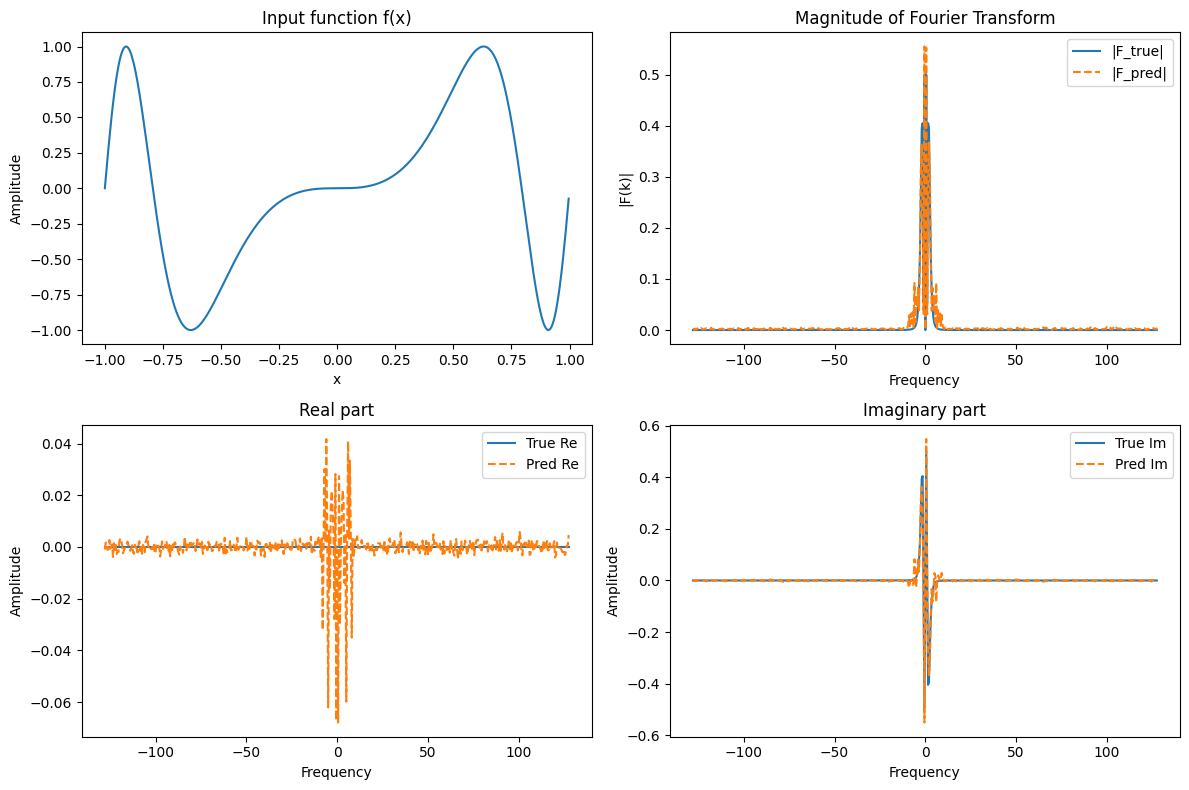

In [7]:
def test_custom_input_plot(func, model, N=512, domain=(-1,1)):
    """
    func  : a Python function of x (e.g., lambda x: np.sin(5*np.pi*x) + 0.5*x**2)
    model : trained FourierNet
    N     : number of discretization points
    domain: tuple of (x_min, x_max)
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import torch

    # Create x-grid
    x = np.linspace(domain[0], domain[1], N, endpoint=False)
    
    # Evaluate function
    f_input = func(x)

    # True FFT
    dx = x[1] - x[0]
    F_true = np.fft.fft(f_input) * dx
    F_true = np.fft.fftshift(F_true)

    # Convert input to tensor and predict
    f_tensor = torch.tensor(f_input, dtype=torch.float32).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        F_pred = model(f_tensor).cpu().numpy()[0]  # shape (N,2)

    # Predicted complex FFT
    F_pred_complex = F_pred[:,0] + 1j*F_pred[:,1]

    # Frequency axis
    freqs = np.fft.fftshift(np.fft.fftfreq(N, d=dx))

    # --- 2x2 plotting ---
    plt.figure(figsize=(12,8))

    # Top-left: input function
    plt.subplot(2,2,1)
    plt.plot(x, f_input)
    plt.title("Input function f(x)")
    plt.xlabel("x")
    plt.ylabel("Amplitude")

    # Top-right: magnitude of FFT
    plt.subplot(2,2,2)
    plt.plot(freqs, np.abs(F_true), label="|F_true|")
    plt.plot(freqs, np.abs(F_pred_complex), '--', label="|F_pred|")
    plt.title("Magnitude of Fourier Transform")
    plt.xlabel("Frequency")
    plt.ylabel("|F(k)|")
    plt.legend()

    # Bottom-left: real part
    plt.subplot(2,2,3)
    plt.plot(freqs, F_true.real, label="True Re")
    plt.plot(freqs, F_pred_complex.real, '--', label="Pred Re")
    plt.title("Real part")
    plt.xlabel("Frequency")
    plt.ylabel("Amplitude")
    plt.legend()

    # Bottom-right: imag part
    plt.subplot(2,2,4)
    plt.plot(freqs, F_true.imag, label="True Im")
    plt.plot(freqs, F_pred_complex.imag, '--', label="Pred Im")
    plt.title("Imaginary part")
    plt.xlabel("Frequency")
    plt.ylabel("Amplitude")
    plt.legend()

    plt.tight_layout()
    plt.show()

test_custom_input_plot(lambda x: np.sin(2*np.pi*x**3), model)